<a href="https://colab.research.google.com/github/alessiomongoli/Sentiment_Lexicon/blob/main/ExperimentPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/alessiomongoli/Sentiment_Lexicon.git

Cloning into 'Sentiment_Lexicon'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 161 (delta 4), reused 0 (delta 0), pack-reused 145
Receiving objects: 100% (161/161), 243.31 KiB | 11.59 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [10]:
!gdown https://drive.google.com/uc?id=1mpL3_URUIDlY0I5MiaCi_tWXqGdA2-6k

Downloading...
From: https://drive.google.com/uc?id=1mpL3_URUIDlY0I5MiaCi_tWXqGdA2-6k
To: /content/glove.840B.300d.pkl
100% 2.80G/2.80G [00:27<00:00, 100MB/s] 


In [ ]:
pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import import_ipynb
import sys
sys.path.append('/content/Sentiment_Lexicon/')

In [ ]:
%cd '/content/Sentiment_Lexicon/'

/content/drive/My Drive/Github/Colab Notebooks/project


In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments.json.gz
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Musical_Instruments.json.gz

In [ ]:
import pandas as pd
import numpy as np


from nltk.corpus import stopwords
import nltk 
import string

from Data_induction.PreProcessing import preprocessing_experiment_price
from Data_induction.TrainSVM import LinearCoefficentsSVM
from glove.Glove import load__all_glove_word, glove_test
from Data_induction.Seed_Data import SeedDataset
from Neural_model.EarlyStopping import EarlyStopping
from Neural_model.Neural import RegressionModel
from Neural_model.Train_predict_NN import train, predict
from Utils.DataframeCreation import creation_dataframe, create_dataframe_price_equal_size ,getDF, parse, compute_statistics_dataframe

importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Data_induction/PreProcessing.ipynb


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Data_induction/TrainSVM.ipynb
importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/glove/Glove.ipynb
importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Data_induction/Seed_Data.ipynb
importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Neural_model/EarlyStopping.ipynb
importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Neural_model/Neural.ipynb
importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Neural_model/Train_predict_NN.ipynb
importing Jupyter notebook from /content/drive/My Drive/Github/Colab Notebooks/project/Utils/DataframeCreation.ipynb


In [ ]:
def experiment_price_dataframe(df, negation_type, category):
  X, y, frequencies, vocabulary = preprocessing_experiment_price(df, negation_type)
  coefficents = LinearCoefficentsSVM(X, y, category, negation_type)
  data = creation_dataframe(vocabulary,coefficents, frequencies)
  return data
  
def searching(vocab):
  top_k = search(vocab, True)
  lowest_k = search(vocab, False)
  pos, neg = count(vocab) 
  return top_k, lowest_k, pos, neg

def search(res, reverse):
  rlist = sorted(res, key=res.get, reverse=reverse)[:] #[:10] if want to select the top 10
  dictionary = {}
  for key in rlist:
    dictionary[key] = res[key]
  return dictionary

In [ ]:
def pipeline_experiment(Data, glove, CATEGORY, negation_type):
  Data = Data[Data['Frequence']>=500]
  Data.reset_index(drop=True, inplace=True)
  Data=Data[Data['Token'].isin(glove.keys())]
  Data.reset_index(drop=True, inplace=True)
  Data['Embedding']=Data['Token'].apply(lambda x: glove[x])
  Data.reset_index(drop=True, inplace=True)
  embedding=dict(zip(Data.Token, Data.Embedding))
  Dataset=SeedDataset(list(Data['Token']),embedding, pol=list(Data['Polarity']))
  trained_model = train(Dataset,CATEGORY, negation_type)
  all_vocabulary= Dataset.get_result()
  glove_wo_pol=glove_test(glove, list(Data['Token']))
  non_seed_data={w:0 for w in glove_wo_pol.keys()}
  non_seed_dataset = SeedDataset(list(non_seed_data.keys()),glove_wo_pol,split='test')
  results = predict(trained_model, non_seed_dataset,CATEGORY, negation_type)
  all_vocabulary.update(results)
  
  return all_vocabulary


In [ ]:
def count(res):
  pos= 0
  neg = 0
  res_filtered = {k: v for k, v in res.items() if v<=-0.1 or v>=0.1}
  for k, v in res_filtered.items():
    if v >= 0:
        pos += 1
    else:
        neg += 1
  return pos, neg

In [ ]:
CATEGORY="reviews_Musical_Instruments"
path_category ='/content/Sentiment_Lexicon/'+CATEGORY+'.json.gz'
path_metadata = '/content/Sentiment_Lexicon/'+'meta_'+CATEGORY[8:]+'.json.gz'
negation_type = 'normal' 
REPOSITORY = '/content/Sentiment_Lexicon/'
SAVE_DATAFRAME_FILE=True

In [ ]:
df_low_price, df_medium_price, df_high_price = create_dataframe_price_equal_size(path_category, path_metadata)
min_low, max_low, mean_price_low, num_reviews_low, mean_lenght_low = compute_statistics_dataframe(df_low_price)
min_medium, max_medium, mean_price_medium, num_reviews_medium, mean_lenght_medium = compute_statistics_dataframe(df_medium_price)
min_high, max_high, mean_price_high, num_reviews_high, mean_lenght_high = compute_statistics_dataframe(df_high_price)

In [ ]:
df_low_price = df_low_price.drop(columns=['price'])
df_medium_price = df_medium_price.drop(columns=['price'])
df_high_price = df_high_price.drop(columns=['price'])

In [ ]:
glove=load__all_glove_word(REPOSITORY+'content/glove.840B.300d.pkl')

In [ ]:
%%time
dataframe_low=experiment_price_dataframe(df_low_price, negation_type ,CATEGORY)
dataframe_medium=experiment_price_dataframe(df_medium_price, negation_type ,CATEGORY)
dataframe_high=experiment_price_dataframe(df_high_price, negation_type ,CATEGORY)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


CPU times: user 2min 52s, sys: 587 ms, total: 2min 52s
Wall time: 2min 52s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
%%time
result_low=pipeline_experiment(dataframe_low,glove, CATEGORY, negation_type)
result_medium=pipeline_experiment(dataframe_medium, glove, CATEGORY, negation_type)
result_high=pipeline_experiment(dataframe_high, glove, CATEGORY, negation_type)

epoch 0:
	Loss decreased (inf --> 0.078810).  Saving model ...
epoch 1:
	Loss decreased (0.078810 --> 0.049104).  Saving model ...
epoch 2:
	Loss decreased (0.049104 --> 0.040814).  Saving model ...
epoch 3:
	Loss decreased (0.040814 --> 0.035461).  Saving model ...
epoch 4:
	Loss decreased (0.035461 --> 0.031257).  Saving model ...
epoch 5:
	Loss decreased (0.031257 --> 0.026301).  Saving model ...
epoch 6:
	Loss decreased (0.026301 --> 0.023560).  Saving model ...
epoch 7:
	Loss decreased (0.023560 --> 0.022738).  Saving model ...
epoch 8:
	Loss decreased (0.022738 --> 0.021539).  Saving model ...
epoch 9:
	Loss decreased (0.021539 --> 0.020532).  Saving model ...
epoch 10:
	Loss decreased (0.020532 --> 0.018177).  Saving model ...
epoch 11: 
	early stopping counter: 1 out of 20
epoch 12:
	Loss decreased (0.018177 --> 0.017465).  Saving model ...
epoch 13:
	Loss decreased (0.017465 --> 0.016755).  Saving model ...
epoch 14:
	Loss decreased (0.016755 --> 0.015790).  Saving model ...
e

In [ ]:
top_k_low, lowest_k_low, pos_low, neg_low=searching(result_low)
top_k_medium, lowest_k_medium, pos_medium, neg_medium=searching(result_medium)
top_k_high, lowest_k_high, pos_high, neg_high=searching(result_high)

In [ ]:
df_result = pd.DataFrame(np.array([['Low', min_low, max_low, mean_price_low, num_reviews_low, mean_lenght_low, pos_low, neg_low, pos_low+neg_low], ['Medium', min_medium, max_medium, mean_price_medium, num_reviews_medium, mean_lenght_medium, pos_medium, neg_medium, pos_medium+neg_medium], ['High', min_high, max_high, mean_price_high, num_reviews_high, mean_lenght_high, pos_high, neg_high, pos_high+neg_high]]),
                   columns=['Price', 'MinPrice', 'MaxPrice', 'MeanPrice', 'Number of reviews', 'Mean Lenght reviews', 'Number positive words', 'Number negative words', 'Total number of words'])

In [ ]:
df_result

,Price,MinPrice,MaxPrice,MeanPrice,Number of reviews,Mean Lenght reviews,Number positive words,Number negative words,Total number of words
0,Low,1,18,9.846415133418482,144845,66.62272083951811,911227,439920,1351147
1,Medium,18,60,33.978280230591324,144845,79.43576236666782,751316,652943,1404259
2,High,60,1000,192.94451310021057,144845,105.94668783872416,911637,712253,1623890


In [ ]:
if SAVE_DATAFRAME_FILE==True:
  df_result.to_csv('/content/Sentiment_Lexicon/Results/'+CATEGORY+'_'+negation_type+'_experiment_price.csv',index=False)

In [ ]:
def get_mean_lenght_reviews(path_category, path_metadata, cat):
  df_low_price, df_medium_price, df_high_price = create_dataframe_price_equal_size(path_category, path_metadata)
  _, _, _, _, mean_lenght_low = compute_statistics_dataframe(df_low_price)
  _, _, _, _, mean_lenght_medium = compute_statistics_dataframe(df_medium_price)
  _, _, _, _, mean_lenght_high = compute_statistics_dataframe(df_high_price)

    
  with open('/content/Sentiment_Lexicon/Results/lenght_review.txt', 'a') as f:
      f.writelines('\n'+cat+' Low Price'+' '+str(mean_lenght_low))
      f.writelines('\n'+cat+' Medium Price'+' '+str(mean_lenght_medium))
      f.writelines('\n'+cat+' High Price'+' '+str(mean_lenght_high))
      f.close()

In [ ]:
lista_categories = ['reviews_Musical_Instruments', 'reviews_Baby', 'reviews_Cell_Phones_and_Accessories', 'reviews_Tools_and_Home_Improvement', 'reviews_Office_Products']

for i, cat in enumerate(lista_categories):
  get_mean_lenght_reviews('/content/Sentiment_Lexicon/'+cat+'.json.gz', '/content/Sentiment_Lexicon/meta_'+cat[8:]+'.json.gz', cat[8:] )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


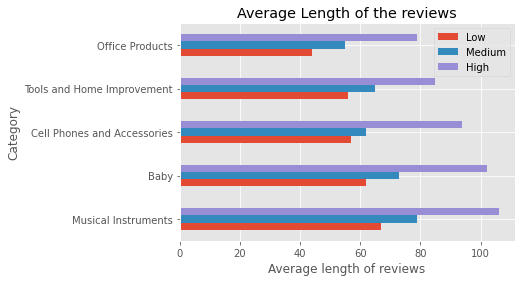

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
  
data = {'Low': [67,62,57,56,44],
        'Medium': [79,73,62,65,55],
        'High': [106,102,94,85,79],
       }
df = pd.DataFrame(data,columns=['Low','Medium', 'High'], index = ['Musical Instruments','Baby','Cell Phones and Accessories','Tools and Home Improvement','Office Products'])

plt.style.use('ggplot')

df.plot.barh()

plt.title('Average Length of the reviews')
plt.ylabel('Category')
plt.xlabel('Average length of reviews')

plt.savefig("image.eps", bbox_inches='tight', pad_inches=0 )

plt.show()